In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import glob
import os

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from tqdm import tqdm
from itertools import product
import shap

In [ ]:
from codecarbon import EmissionsTracker

codecarbon_output = "./codecarbon_emissions_xgboost.csv"

In [3]:
arquivos = ['Interpolado_Marambaia.csv', 'Interpolado_VilaMilitar.csv', 'Interpolado_jacarepagua.csv']
dfs = [pd.read_csv(a, sep=',', encoding='utf8') for a in arquivos]
df = pd.concat(dfs, ignore_index=True)
df = df.sort_values(['datetime'], ignore_index=True)
df


,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",datetime
0,0.0,1021.400000,1021.400000,1021.100000,0.0,18.200000,15.700000,18.200000,18.0,15.800000,15.40,86.000000,85.0,86.0,28.0,3.8,2.000000,2002-11-08 00:00:00
1,0.0,1021.900000,1022.000000,1021.400000,0.0,18.500000,16.200000,18.600000,18.2,16.300000,15.70,87.000000,85.0,87.0,348.0,5.9,2.500000,2002-11-08 01:00:00
2,3.6,1021.700000,1022.500000,1021.700000,0.0,17.800000,15.900000,18.500000,17.6,16.400000,15.40,89.000000,86.0,89.0,17.0,6.1,2.500000,2002-11-08 02:00:00
3,0.0,1020.900000,1021.700000,1020.900000,0.0,17.400000,15.700000,17.800000,17.4,15.900000,15.70,90.000000,89.0,90.0,29.0,3.0,1.800000,2002-11-08 03:00:00
4,0.0,1020.300000,1020.800000,1020.300000,0.0,17.200000,15.600000,17.400000,17.2,15.800000,15.60,91.000000,90.0,91.0,2.0,3.9,2.400000,2002-11-08 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414824,0.0,1017.800000,1017.800000,1017.400000,3.7,20.700000,17.900000,20.800000,20.1,17.900000,17.50,85.000000,82.0,84.0,256.0,3.5,0.800000,2025-05-31 21:00:00
414825,0.0,1018.200000,1018.200000,1017.700000,0.0,21.400000,17.900000,21.400000,20.7,18.000000,17.90,84.000000,80.0,81.0,237.0,6.2,1.600000,2025-05-31 22:00:00
414826,0.0,1019.088889,1019.088889,1018.533333,0.0,20.009091,18.066667,21.009091,20.2,18.585714,17.35,85.857143,78.0,86.0,47.0,7.6,2.376190,2025-05-31 22:00:00
414827,0.0,1019.733333,1019.733333,1019.000000,0.0,19.254545,18.300000,20.754545,19.7,18.614286,16.80,86.142857,70.0,89.0,81.0,10.6,6.257143,2025-05-31 23:00:00


Partição precipitação, temperatura e umidade, respectivamente

In [4]:
X_prec = df[[
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'TEMPERATURA DO PONTO DE ORVALHO (°C)',
       'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 
       'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'
    ]]

y_prec = df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']

In [5]:
X_temp = df[[
       'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 
       'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'
    ]]

y_temp = df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']

In [6]:
X_umid = df[[
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'TEMPERATURA DO PONTO DE ORVALHO (°C)',
       'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 
       'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'
    ]]

y_umid = df['UMIDADE RELATIVA DO AR, HORARIA (%)']

funções

In [7]:
def split_train_test(X, y, train_size):
    X_train, X_test = X[:round(X.shape[0]*train_size)], X[round(X.shape[0]*train_size):]
    y_train, y_test = y[:round(y.shape[0]*train_size)], y[round(y.shape[0]*train_size):]

    return X_train, X_test, y_train, y_test

def train_xgboost(X_train, y_train, X_test, y_test, params):
    xgb_model = xgb.train(params, xgb.DMatrix(X_train, label=y_train), num_boost_round=100)
    
    predictions = xgb_model.predict(xgb.DMatrix(X_test))
    
    rmse = mean_squared_error(y_test, predictions)
    
    return xgb_model, predictions
    
def grid_search_xgboost(X_train, y_train, X_test, y_test):
    param_grid = {
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'min_child_weight': [1, 3, 5]
    }
    
    param_combinations = list(product(
        param_grid['max_depth'],
        param_grid['learning_rate'],
        param_grid['subsample'],
        param_grid['colsample_bytree'],
        param_grid['min_child_weight']
    ))
    
    best_rmse = float('inf')
    best_params = None

    for combination in tqdm(param_combinations, desc="Grid Search Progress"):
        max_depth, learning_rate, subsample, colsample_bytree, min_child_weight = combination
        params = {
            'max_depth': max_depth,
            'eta': learning_rate,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'min_child_weight': min_child_weight,
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse'
        }
        
        model, predictions = train_xgboost(X_train, y_train, X_test, y_test, params)
        rmse = mean_squared_error(y_test, predictions)
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
    
    print("Best parameters found:")
    print(best_params)
    print(f"Best RMSE: {best_rmse}")
    
    final_model, final_predictions = train_xgboost(X_train, y_train, X_test, y_test, best_params)
    
    return final_model, final_predictions, best_params

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MRSE: {np.sqrt(mean_squared_error(y_test, prediction))}")

def plot_real_vs_predicted(y_test, predictions, save=False):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, predictions, alpha=0.7, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2, label="Ideal Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Real vs Predicted Values")
    plt.legend()
    plt.grid(True)

    if save: 
        plt.savefig(save)
    
    plt.show()

def plot_prediction_over_time(y_test, predictions, timestamps, start_date=None, end_date=None, save=False):
    timestamps = pd.to_datetime(timestamps)

    data = pd.DataFrame({
        'Timestamp': timestamps,
        'Actual': y_test,
        'Predicted': predictions
    })

    if start_date:
        data = data[data['Timestamp'] >= pd.to_datetime(start_date)]
    if end_date:
        data = data[data['Timestamp'] <= pd.to_datetime(end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(data['Timestamp'], data['Actual'], label='Actual Values', color='blue', linewidth=2)
    plt.plot(data['Timestamp'], data['Predicted'], label='Predicted Values', color='orange', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Actual vs. Predicted Values Over Time')
    plt.legend()
    plt.grid(True)

    
    if save: 
        plt.savefig(save)
        
    plt.show()

In [8]:
timestamps_test = df.iloc[round(df.shape[0] * 0.8):]["datetime"]

In [ ]:
Precipitação xgboost

In [9]:
X_train, X_test, y_train, y_test = split_train_test(X_prec, y_prec, 0.8)

tracker = EmissionsTracker(
    project_name="xgboost precipiptation train 0.8",
    output_file='./codecarbon_emissions_jac_mar_vm.csv',
    log_level = "critical"
)

tracker.start()

prec_model, prec_predictions, prec_best_params = grid_search_xgboost(X_train, y_train, X_test, y_test)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

[codecarbon WARNING @ 20:14:55] Multiple instances of codecarbon are allowed to run at the same time.
Grid Search Progress: 100%|██████████| 243/243 [26:07<00:00,  6.45s/it]


Best parameters found:
{'max_depth': 6, 'eta': 0.01, 'subsample': 0.8, 'colsample_bytree': 0.6, 'min_child_weight': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
Best RMSE: 1.3986306764634406
emissions=0.00012673187263633574


In [10]:
evaluate_model(y_test, prec_predictions)

MAE: 0.2782537900542987
MSE: 1.3986306764634406
MRSE: 1.1826371702527536


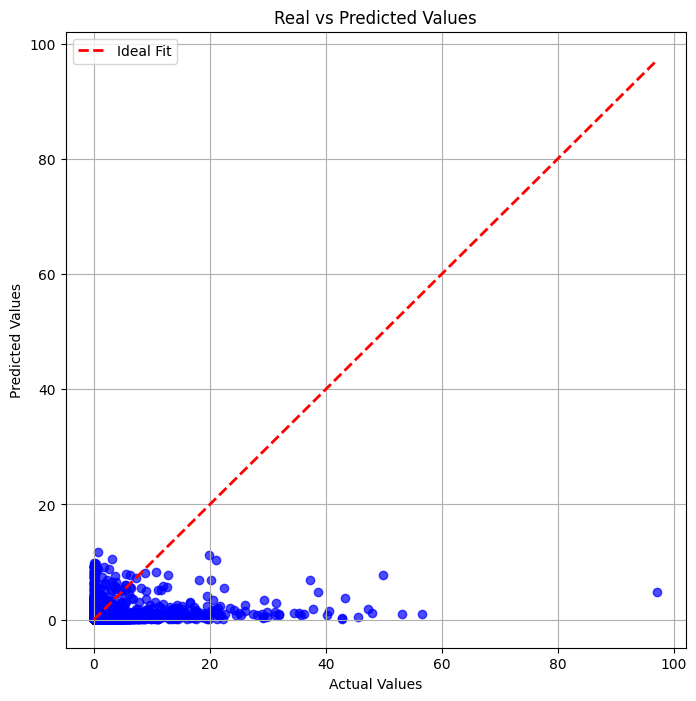

In [11]:
plot_real_vs_predicted(y_test, prec_predictions, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_prec_real_geral_bases_integradas.png')


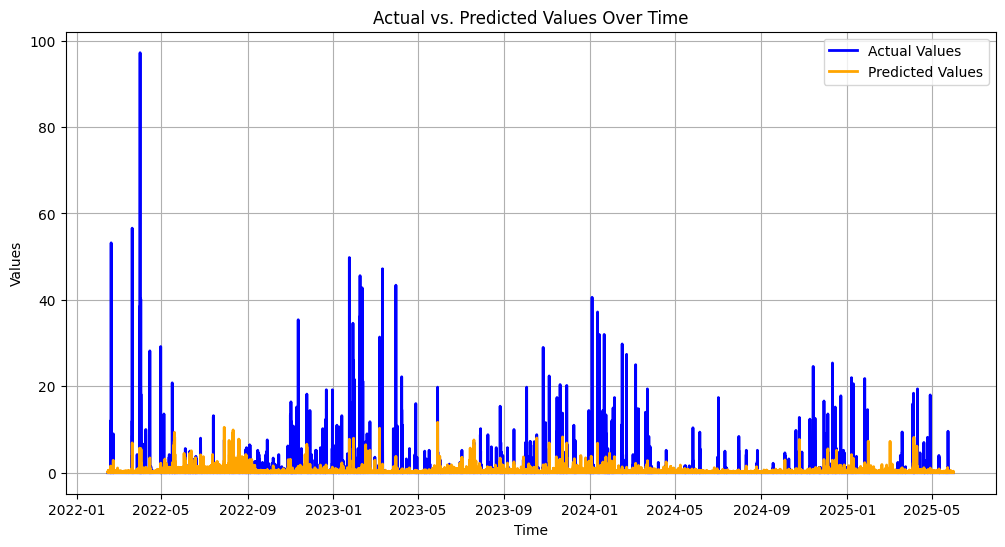

In [12]:
plot_prediction_over_time(y_test, prec_predictions, timestamps_test)


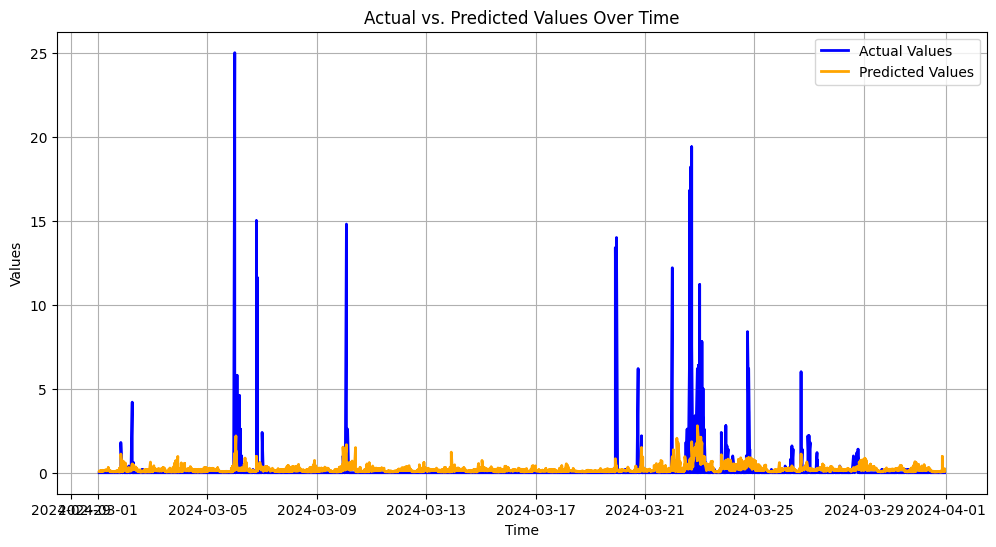

In [13]:
start_date = "2024-03-01 01:00:00"
end_date = "2024-03-31 23:00:00"

plot_prediction_over_time(y_test, prec_predictions, timestamps_test, start_date, end_date, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_prec_real_03-2024_bases_integradas.png')

In [14]:
explainer = shap.Explainer(prec_model, X_train[:100])
shap_values = explainer(X_test)

100%|===================| 82888/82966 [11:26<00:00]        

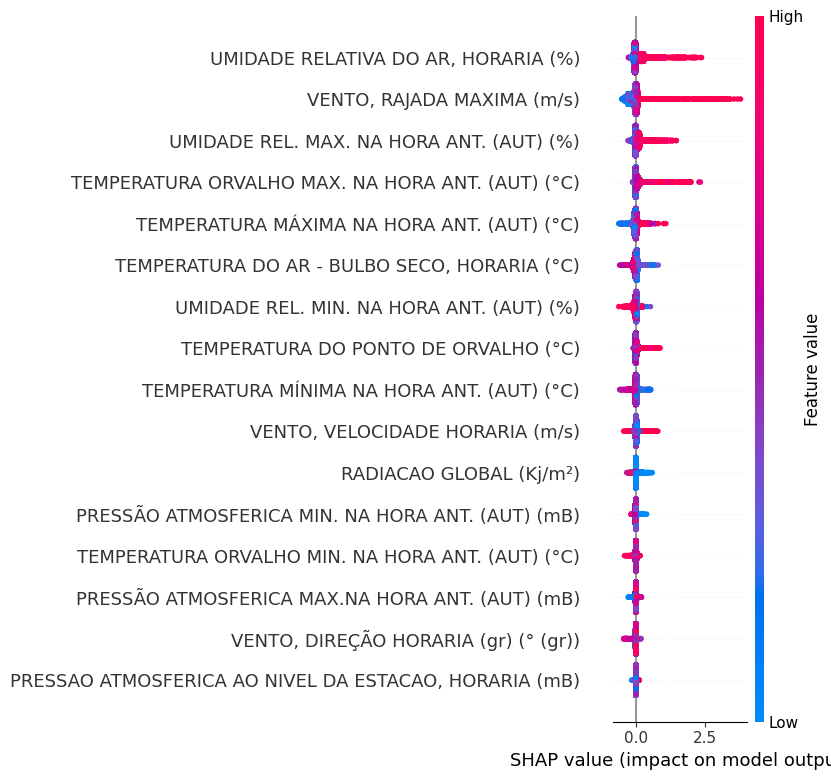

In [15]:
shap.summary_plot(shap_values.values, X_test)

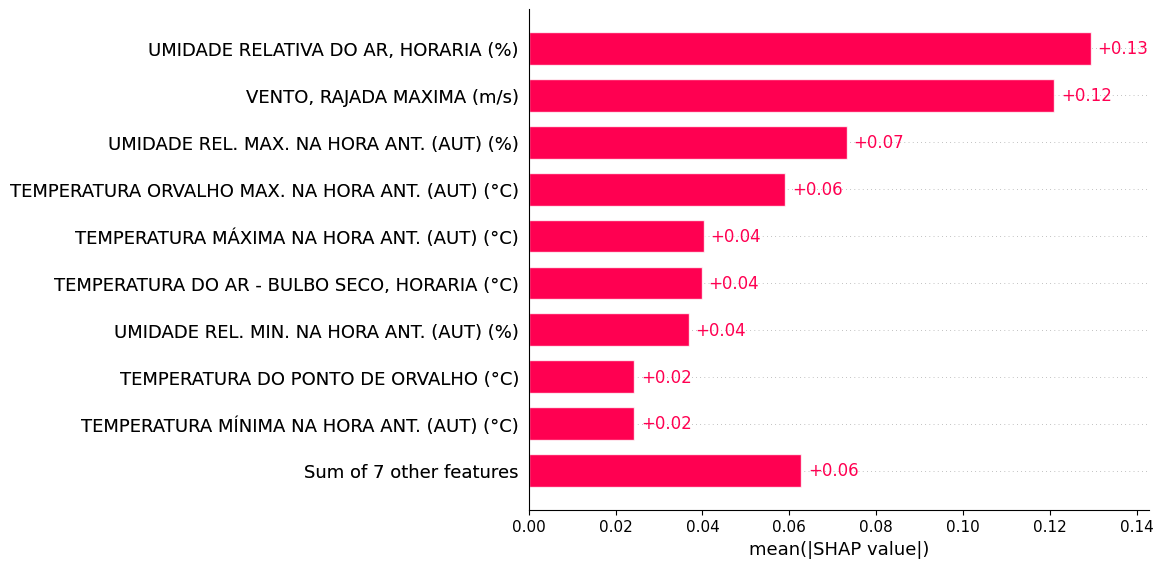

In [16]:
shap.plots.bar(shap_values)

temperatura xgboost

In [17]:
X_train, X_test, y_train, y_test = split_train_test(X_temp, y_temp, 0.8)

tracker = EmissionsTracker(
    project_name="xgboost temperature train 0.8",
    output_file='./codecarbon_emissions_jac_mar_vm.csv',
    log_level = "critical"
)

tracker.start()

temp_model, temp_predictions, temp_best_params = grid_search_xgboost(X_train, y_train, X_test, y_test)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

Grid Search Progress: 100%|██████████| 243/243 [39:48<00:00,  9.83s/it]


Best parameters found:
{'max_depth': 6, 'eta': 0.2, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 5, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
Best RMSE: 5.4074748968770265
emissions=0.00019296367829478635


In [18]:
evaluate_model(y_test, temp_predictions)

MAE: 1.8148375114309407
MSE: 5.4074748968770265
MRSE: 2.3253977932553878


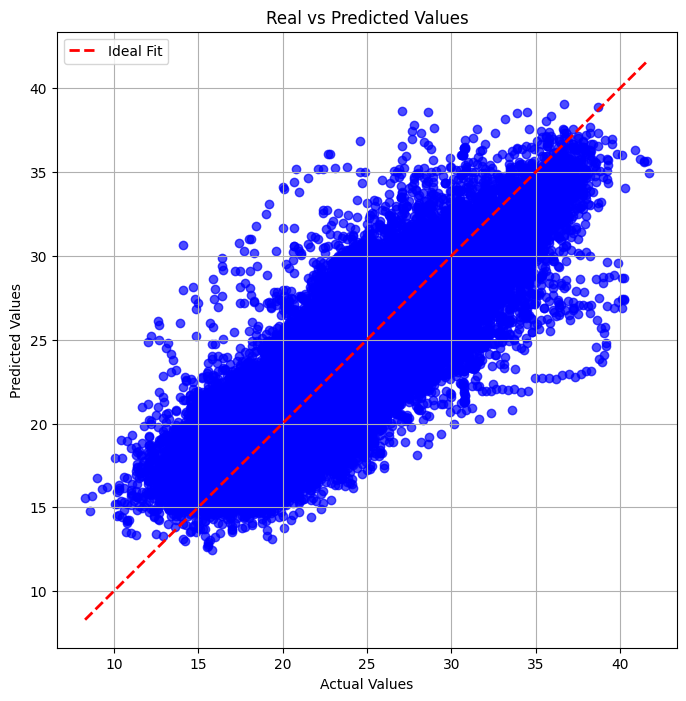

In [19]:
plot_real_vs_predicted(y_test, temp_predictions, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_temp_real_geral_bases_integradas.png')


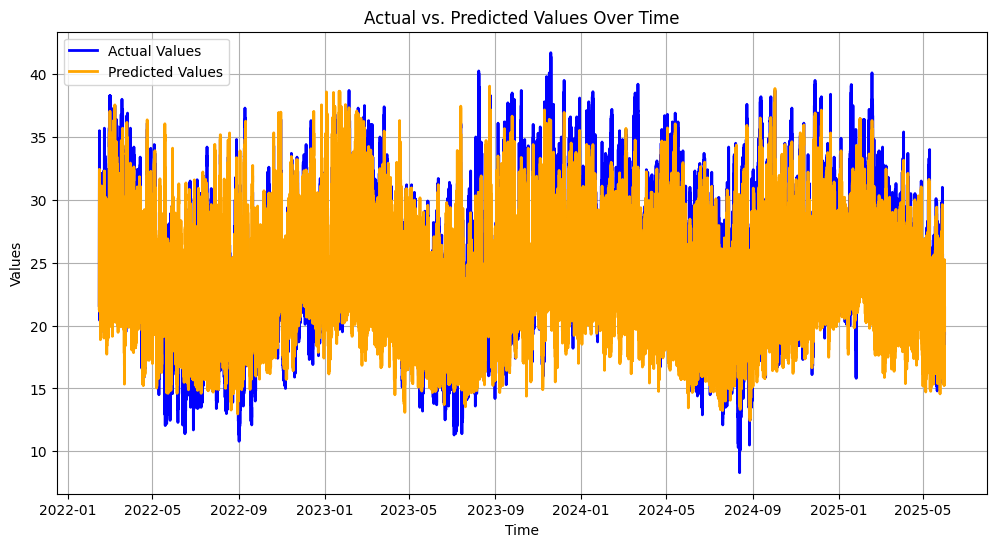

In [20]:
plot_prediction_over_time(y_test, temp_predictions, timestamps_test)

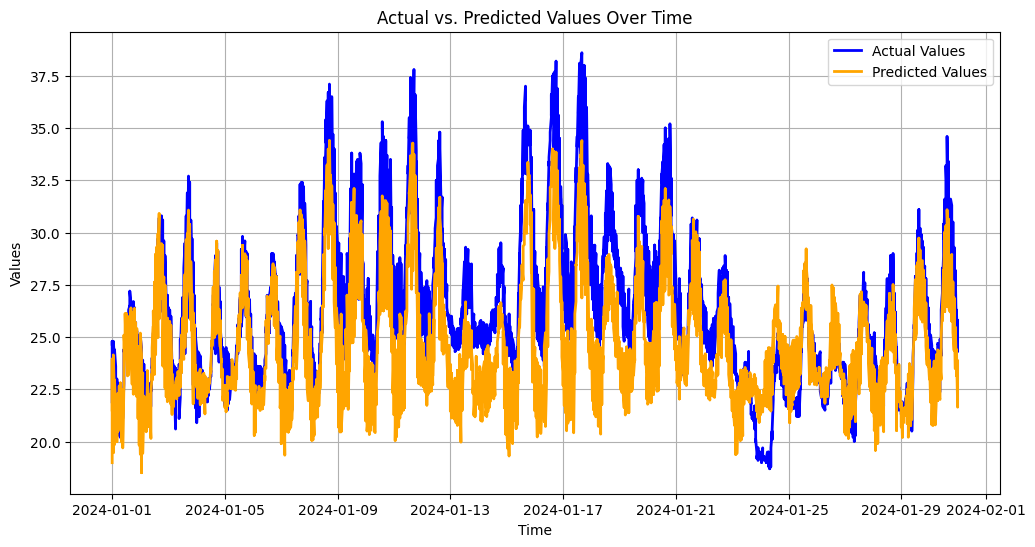

In [21]:
start_date = "2024-01-01"
end_date = "2024-01-31"

plot_prediction_over_time(y_test, temp_predictions, timestamps_test, start_date, end_date, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_temp_real_2024-01_bases_integradas.png')

In [23]:
explainer = shap.Explainer(temp_model, X_train[:100])
shap_values = explainer(X_test)

100%|===================| 82963/82966 [11:48<00:00]        

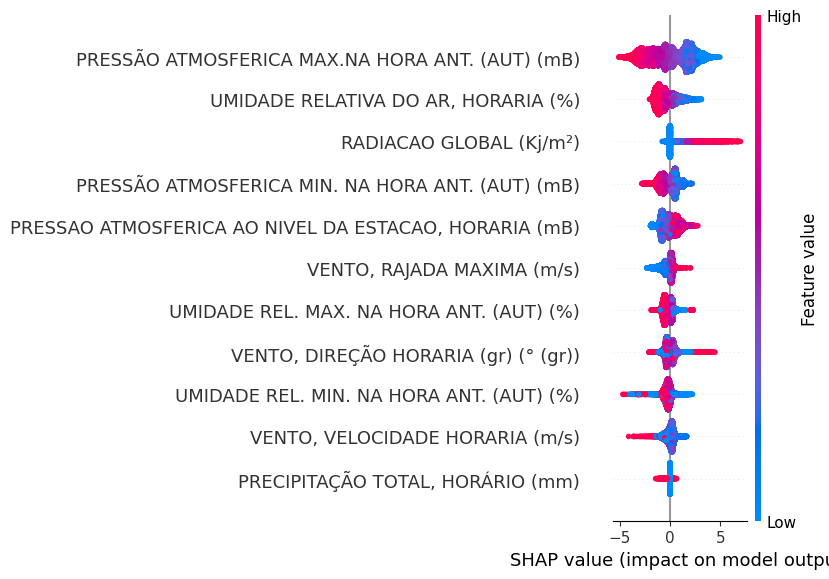

In [24]:
shap.summary_plot(shap_values.values, X_test)

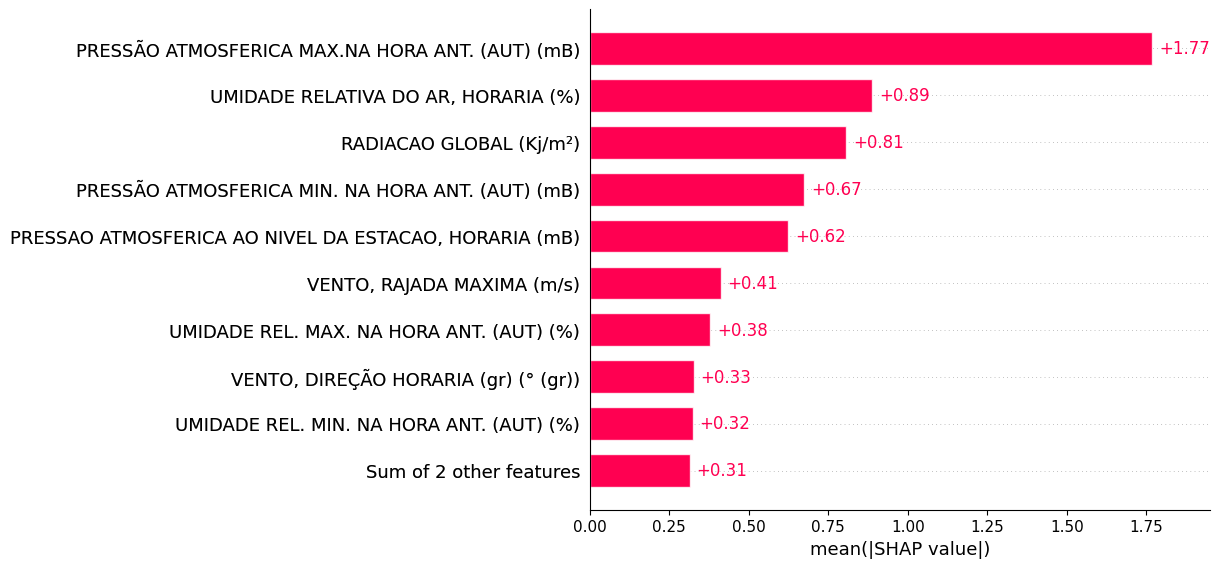

In [25]:
shap.plots.bar(shap_values)

umidade xgboost

In [26]:
X_train, X_test, y_train, y_test = split_train_test(X_umid, y_umid, 0.8)

tracker = EmissionsTracker(
    project_name="xgboost umidity train 0.8",
    output_file='./codecarbon_emissions_jac_mar_vm.csv',
    log_level = "critical"
)

tracker.start()

umid_model, umid_predictions, umid_best_params = grid_search_xgboost(X_train, y_train, X_test, y_test)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

Grid Search Progress: 100%|██████████| 243/243 [20:04<00:00,  4.95s/it]


Best parameters found:
{'max_depth': 4, 'eta': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.6, 'min_child_weight': 5, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
Best RMSE: 113.19560929398412
emissions=9.723051749965881e-05


In [27]:
evaluate_model(y_test, umid_predictions)

MAE: 5.047620170709795
MSE: 113.19560929398412
MRSE: 10.63934252169673


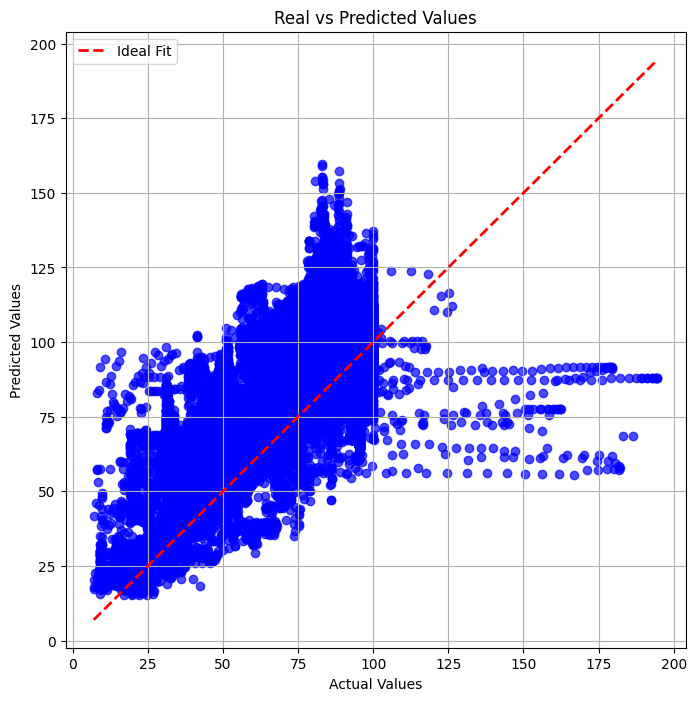

In [28]:
plot_real_vs_predicted(y_test, umid_predictions, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_umid_real_geral_bases_integradas.png')


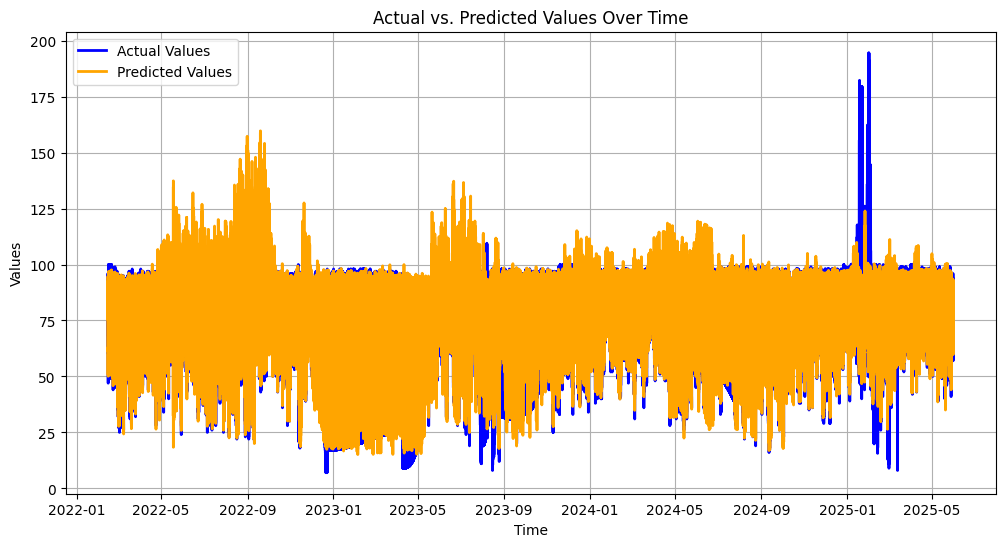

In [29]:
plot_prediction_over_time(y_test, umid_predictions, timestamps_test)

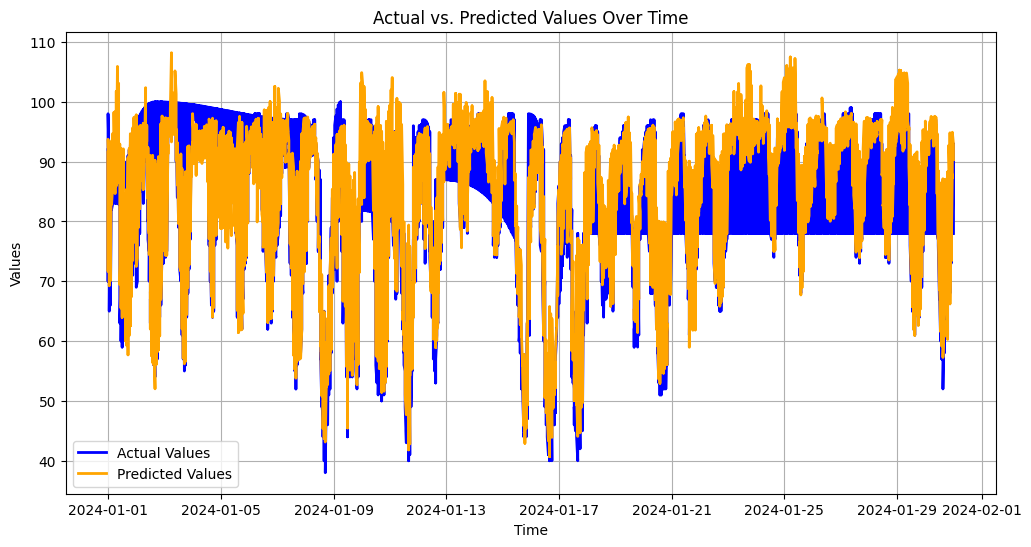

In [30]:
start_date = "2024-01-01"
end_date = "2024-01-31"

plot_prediction_over_time(y_test, umid_predictions, timestamps_test, start_date, end_date, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_umid_real_2024-01_bases_integradas.png')

In [31]:
explainer = shap.Explainer(umid_model, X_train[:100])
shap_values = explainer(X_test)

100%|===================| 82921/82966 [03:52<00:00]        

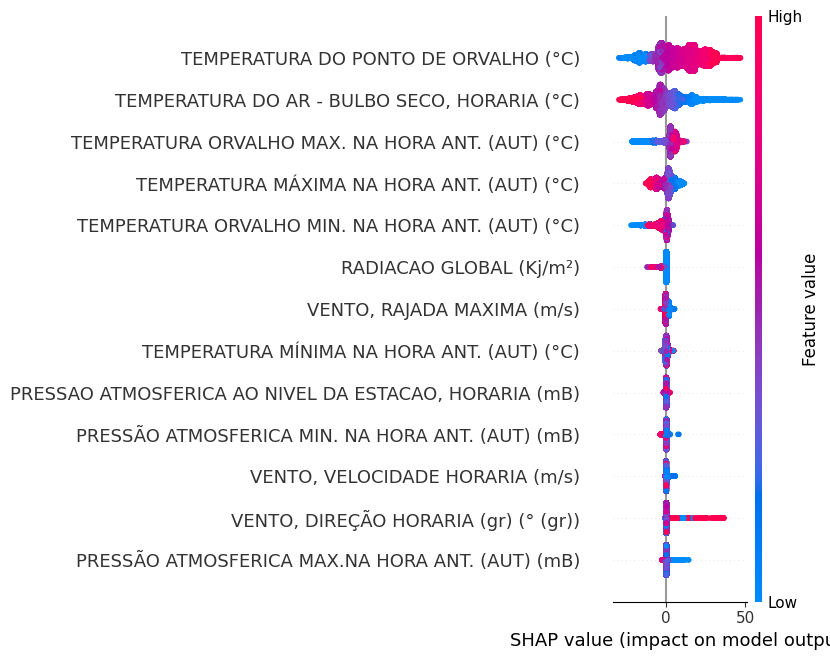

In [32]:
shap.summary_plot(shap_values.values, X_test)

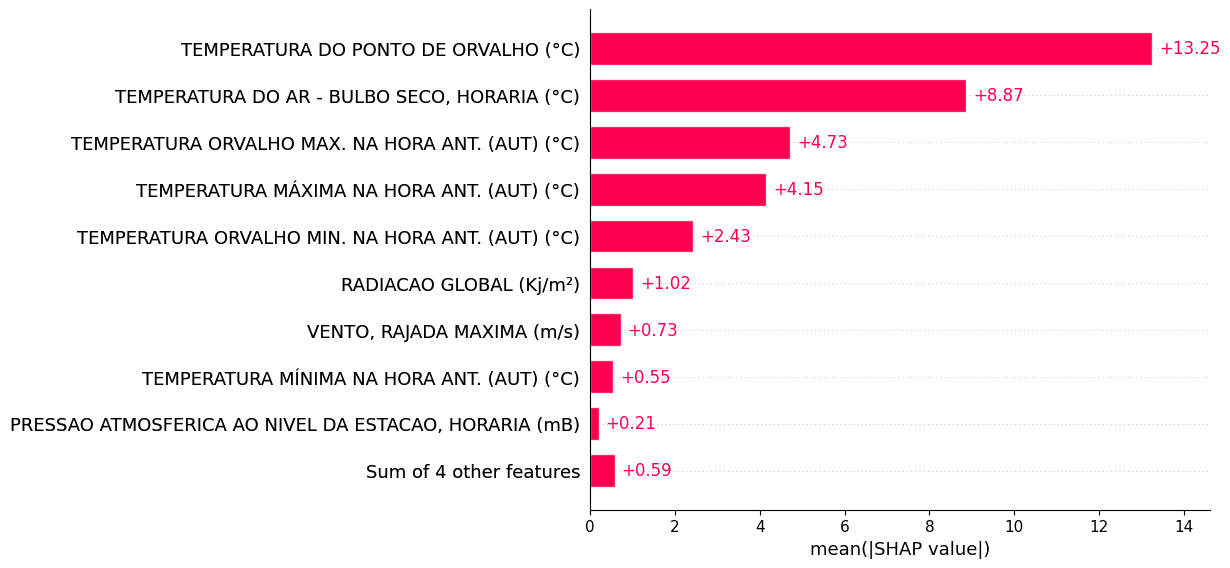

In [33]:
shap.plots.bar(shap_values)